---
> # **BACKTEST** - Estratégia _Big Barra_
---

A estratégia é assim:

* Timeframe de 5min;
* Indicadores:
  * HMA no periodo 20
  * Outside bar (mínima do candle atual menor do que a mínima do candle anterior e máxima do candle atual maior do que a máxima do candle anterior
* Sinal de entrada de compra:
  * Candle Big Barra fecha acima da HMA
  * A entrada ocorre quando acontece o rompimento da máxima + 10 pontos da Big Barra
* Sinal de entrada de venda:
  * Candle Big Barra fecha abaixo da HMA
  * A entrada ocorre quando acontece o rompimento da mínima - 10 pontos da Big Barra
* Stop na mínima do candle e alvo 50% e 100% do stop; ao bater os 50% realizar parcial e mover o stop para a entrada.


_OBS.:_ estratégia retirada do canal do **Edimar Castro** no vídeo: [MINI INDICE - SETUP DA BIG BARRA](https://www.youtube.com/watch?v=6eQ4JX2XiNw)

# 1. Bibliotecas

In [1]:
# Análise e manipulação de dados gerais
import numpy as np
import pandas as pd

import pandas_ta as ta

# Dados séries temporais
from datetime import datetime, timedelta
import pytz

# Dados OHLCV
from mt5linux import MetaTrader5

# connecto to the server
mt5 = MetaTrader5()
mt5.execute('import datetime')

# Bibliotecas gráficas
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
mt5.initialize()

True

In [3]:
def get_data(ticker, timeframe, data_inicio, data_fim):
    dados_ohlcv = mt5.copy_rates_range(ticker, timeframe, data_inicio, data_fim)
    dados_ohlcv = pd.DataFrame(dados_ohlcv)
    dados_ohlcv['ticker'] = str(ticker)
    dados_ohlcv.index = pd.to_datetime(dados_ohlcv['time'], unit='s')
    dados_ohlcv = dados_ohlcv.drop('time', axis=1)
    
    return dados_ohlcv

In [4]:
def sinal_compra(close, hma, high, low):
    high_ant = high.shift(1)
    low_ant = low.shift(1)
    
    regra1 = close > hma
    regra2 = (high > high_ant) & (low < low_ant)
    
    return regra1 & regra2

def sinal_venda(close, hma, high, low):
    high_ant = high.shift(1)
    low_ant = low.shift(1)
    
    regra1 = close < hma
    regra2 = (high > high_ant) & (low < low_ant)
    
    return regra1 & regra2

In [5]:
timezone = pytz.timezone("America/Sao_Paulo")
data_inicio = datetime(2020,1,1)#datetime.now() - timedelta(days=1050)
data_fim = datetime.now()

# 2. Obtenção dos dados

In [6]:
ticker = 'WIN$N'

df = get_data(ticker, mt5.TIMEFRAME_M5, data_inicio, data_fim)
df['hma'] = ta.hma(df.close, length=20)
df['compra'] = sinal_compra(df.close, df.hma, df.high, df.low)
df['venda'] = sinal_venda(df.close, df.hma, df.high, df.low)
df.head()

,open,high,low,close,tick_volume,spread,real_volume,ticker,hma,compra,venda
time,,,,,,,,,,,
2020-01-02 09:00:00,117070.0,117170.0,117020.0,117145.0,12658,5,61538,WIN$N,NaN,False,False
2020-01-02 09:05:00,117140.0,117240.0,117045.0,117225.0,16174,5,72643,WIN$N,NaN,False,False
2020-01-02 09:10:00,117225.0,117250.0,117145.0,117150.0,12359,5,49335,WIN$N,NaN,False,False
2020-01-02 09:15:00,117150.0,117170.0,117110.0,117125.0,9840,5,39651,WIN$N,NaN,False,False
2020-01-02 09:20:00,117130.0,117145.0,117095.0,117130.0,7253,5,32205,WIN$N,NaN,False,False


## 2.1 Filtro de compra

In [7]:
df_compra = df[df.compra == True]
df_compra.tail()

,open,high,low,close,tick_volume,spread,real_volume,ticker,hma,compra,venda
time,,,,,,,,,,,
2023-04-10 10:35:00,101845.0,102275.0,101785.0,102265.0,26883,0,355529,WIN$N,101973.148701,True,False
2023-04-10 14:35:00,101850.0,101945.0,101815.0,101905.0,8654,0,85488,WIN$N,101826.707792,True,False
2023-04-10 15:00:00,101845.0,101925.0,101785.0,101915.0,9450,0,112393,WIN$N,101878.930303,True,False
2023-04-10 16:45:00,101860.0,101930.0,101815.0,101925.0,6046,0,77093,WIN$N,101880.140693,True,False
2023-04-11 11:25:00,105610.0,105725.0,105385.0,105515.0,21265,0,235496,WIN$N,105452.807576,True,False


## 2.2 Filtro de Venda

In [8]:
df_venda = df[df.venda == True]
df_venda.tail()

,open,high,low,close,tick_volume,spread,real_volume,ticker,hma,compra,venda
time,,,,,,,,,,,
2023-04-10 09:20:00,101025.0,101040.0,100885.0,100970.0,12786,0,135968,WIN$N,101145.338095,False,True
2023-04-10 14:15:00,101905.0,101925.0,101790.0,101795.0,8269,0,89154,WIN$N,101840.809957,False,True
2023-04-10 15:50:00,101865.0,101930.0,101800.0,101815.0,9556,0,106183,WIN$N,101880.268831,False,True
2023-04-10 17:50:00,102035.0,102100.0,102000.0,102020.0,2825,0,30806,WIN$N,102053.109740,False,True
2023-04-11 12:05:00,105400.0,105485.0,105220.0,105265.0,14438,0,150580,WIN$N,105379.786797,False,True


## 2.3 Visualizando as entradas de compra

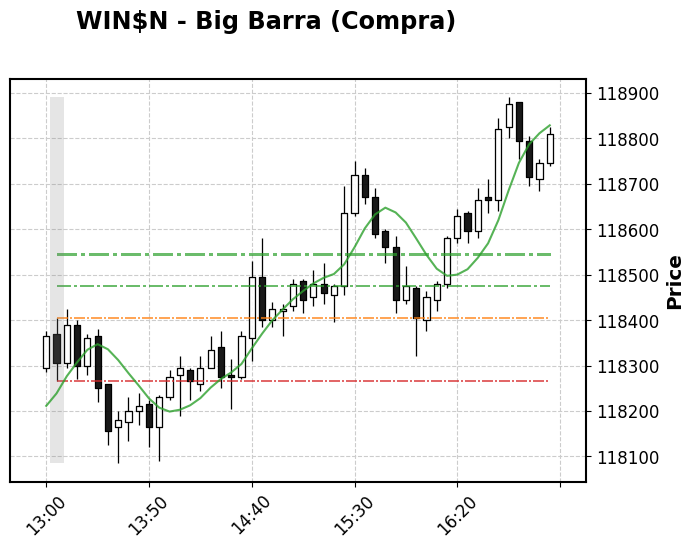

In [9]:
n_index = 0
inicio = df_compra.iloc[n_index].name - timedelta(minutes=5)
fim = df_compra.iloc[n_index].name + timedelta(minutes=240)

stop = 1.
take1 = .5
take2 = 1.

candle_index = 1

dfpl = df.loc[inicio:fim]

candle_signal = dfpl.index[candle_index].strftime('%Y-%m-%d %H:%M:%S')
candle_end = dfpl.index[-1].strftime('%Y-%m-%d %H:%M:%S')

ponto_entrada = dfpl['high'].loc[candle_signal]
ponto_stop = dfpl['high'].loc[candle_signal] - ((dfpl['high'].loc[candle_signal] - dfpl['low'].loc[candle_signal]) * stop)
ponto_take1 = dfpl['high'].loc[candle_signal] + ((dfpl['high'].loc[candle_signal] - dfpl['low'].loc[candle_signal]) * take1)
ponto_take2 = dfpl['high'].loc[candle_signal] + ((dfpl['high'].loc[candle_signal] - dfpl['low'].loc[candle_signal]) * take2)

lines = [[(candle_signal,ponto_stop),(candle_end, ponto_stop)],
         [(candle_signal,ponto_entrada),(candle_end, ponto_entrada)],
         [(candle_signal,ponto_take1),(candle_end, ponto_take1)],
        [(candle_signal,ponto_take2),(candle_end, ponto_take2)]]

adp = [mpf.make_addplot(dfpl.hma, color='tab:green', width=1.5, alpha=0.8),]

alines = dict(alines=lines, linestyle='-.', colors=['tab:red', 'tab:orange', 'tab:green', 'tab:green'], alpha=0.7, linewidths=[1.2,1.2,1.5,2.2,])
vlines=dict(vlines=candle_signal,linewidths=10, alpha=0.2, colors='tab:gray')
mpf.plot(dfpl, title=f'{ticker} - Big Barra (Compra)', type='candle', style='classic', vlines=vlines, alines=alines, addplot=adp)

## 2.4 Visualizando as entradas de venda

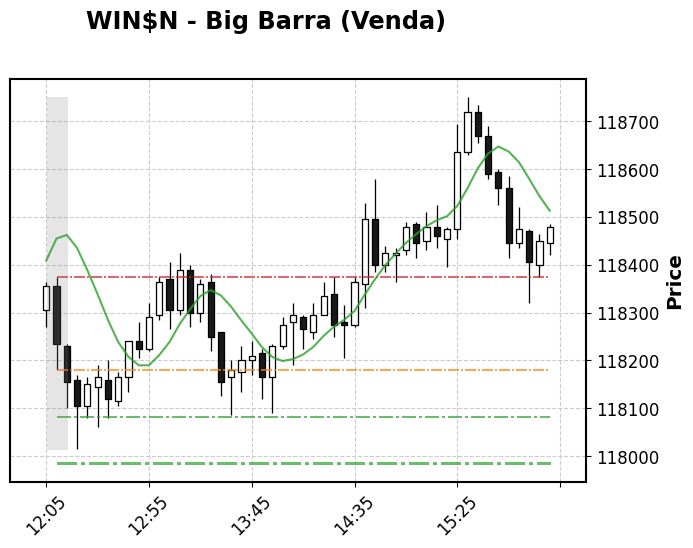

In [10]:
n_index = 3
inicio = df_venda.iloc[n_index].name - timedelta(minutes=5)
fim = df_venda.iloc[n_index].name + timedelta(minutes=240)

stop = 1.
take1 = .5
take2 = 1.

candle_index = 1

dfpl = df.loc[inicio:fim]

candle_signal = dfpl.index[candle_index].strftime('%Y-%m-%d %H:%M:%S')
candle_end = dfpl.index[-1].strftime('%Y-%m-%d %H:%M:%S')

ponto_entrada = dfpl['low'].loc[candle_signal]
ponto_stop = dfpl['low'].loc[candle_signal] + ((dfpl['high'].loc[candle_signal] - dfpl['low'].loc[candle_signal]) * stop)
ponto_take1 = dfpl['low'].loc[candle_signal] - ((dfpl['high'].loc[candle_signal] - dfpl['low'].loc[candle_signal]) * take1)
ponto_take2 = dfpl['low'].loc[candle_signal] - ((dfpl['high'].loc[candle_signal] - dfpl['low'].loc[candle_signal]) * take2)

lines = [[(candle_signal,ponto_stop),(candle_end, ponto_stop)],
         [(candle_signal,ponto_entrada),(candle_end, ponto_entrada)],
         [(candle_signal,ponto_take1),(candle_end, ponto_take1)],
        [(candle_signal,ponto_take2),(candle_end, ponto_take2)]]

adp = [mpf.make_addplot(dfpl.hma, color='tab:green', width=1.5, alpha=0.8),]

alines = dict(alines=lines, linestyle='-.', colors=['tab:red', 'tab:orange', 'tab:green', 'tab:green'], alpha=0.7, linewidths=[1.2,1.2,1.5,2.2,])
vlines=dict(vlines=candle_signal,linewidths=15, alpha=0.2, colors='tab:gray')
mpf.plot(dfpl, title=f'{ticker} - Big Barra (Venda)', type='candle', style='classic', vlines=vlines, alines=alines, addplot=adp)

# 3. Backtest

In [11]:
position_compra = 0
position_venda = 0

min_tick = 5

stop = 1.
alvo1 = 0.5
alvo2 = 1.

n_trade = 0

entrada_compra = {'n_trade':[], 'data':[], 'preco':[]}
saida_compra_SL = {'n_trade':[], 'data':[], 'preco':[], 'position_SL':[]}
saida_compra_TP1 = {'n_trade':[], 'data':[], 'preco':[]}
saida_compra_TP2 = {'n_trade':[], 'data':[], 'preco':[]}

entrada_venda = {'n_trade':[], 'data':[], 'preco':[]}
saida_venda_SL = {'n_trade':[], 'data':[], 'preco':[], 'position_SL':[]}
saida_venda_TP1 = {'n_trade':[], 'data':[], 'preco':[]}
saida_venda_TP2 = {'n_trade':[], 'data':[], 'preco':[]}

for i in range(len(df)):
    if ((position_compra == 0) and (position_venda == 0)) and (df['compra'].iloc[i] == True):
        ponto_entrada = df['high'].iloc[i] + (2*min_tick)
        stop_loss = ponto_entrada - ((ponto_entrada - df['low'].iloc[i]) * stop)
        take_profit1 = ponto_entrada + ((ponto_entrada - df['low'].iloc[i]) * alvo1)
        take_profit2 = ponto_entrada + ((ponto_entrada - df['low'].iloc[i]) * alvo2)
        
        pos_compra = i
        max_index = pos_compra + 3
        
        while (df.index[pos_compra].hour < 16) and (position_compra == 0) and (pos_compra < max_index):
            if df['high'].iloc[pos_compra] >= ponto_entrada:
                n_trade += 1
                position_compra = 1
                
                entrada_compra['n_trade'].append(n_trade)
                entrada_compra['data'].append(df.index[pos_compra])
                entrada_compra['preco'].append(ponto_entrada)
            pos_compra += 1
    if ((position_compra > 0) and (position_venda == 0)) and (i >= pos_compra) and (df.low.iloc[i] <= stop_loss):
        saida_compra_SL['n_trade'].append(n_trade)
        saida_compra_SL['data'].append(df.index[i])
        saida_compra_SL['preco'].append(stop_loss)
        saida_compra_SL['position_SL'].append(position_compra)
        position_compra = 0
    if ((position_compra == 1) and (position_venda == 0)) and (i >= pos_compra) and (df.high.iloc[i] >= take_profit1):
        saida_compra_TP1['n_trade'].append(n_trade)
        saida_compra_TP1['data'].append(df.index[i])
        saida_compra_TP1['preco'].append(take_profit1)
        position_compra = 0.5
        stop_loss = ponto_entrada
    if ((position_compra == 0.5) and (position_venda == 0)) and (i >= pos_compra) and (df.high.iloc[i] >= take_profit2):
        saida_compra_TP2['n_trade'].append(n_trade)
        saida_compra_TP2['data'].append(df.index[i])
        saida_compra_TP2['preco'].append(take_profit2)
        position_compra = 0
        
    if ((position_venda == 0) and (position_compra == 0)) and (df['venda'].iloc[i] == True):
        ponto_entrada = df['low'].iloc[i] - (2*min_tick)
        stop_loss = ponto_entrada + ((df['high'].iloc[i] - ponto_entrada) * stop)
        take_profit1 = ponto_entrada - ((df['high'].iloc[i] - ponto_entrada) * alvo1)
        take_profit2 = ponto_entrada - ((df['high'].iloc[i] - ponto_entrada) * alvo2)
        
        pos_venda = i
        max_index = pos_venda + 3
        
        while (df.index[pos_venda].hour < 16) and (position_venda == 0) and (pos_venda < max_index):
            
            if df['low'].iloc[pos_venda] <= ponto_entrada:
                n_trade += 1
                position_venda = 1
                
                entrada_venda['n_trade'].append(n_trade)
                entrada_venda['data'].append(df.index[pos_venda])
                entrada_venda['preco'].append(ponto_entrada)
            pos_venda += 1
    if ((position_venda > 0) and (position_compra == 0)) and (i >= pos_venda) and (df.high.iloc[i] >= stop_loss):
        saida_venda_SL['n_trade'].append(n_trade)
        saida_venda_SL['data'].append(df.index[i])
        saida_venda_SL['preco'].append(stop_loss)
        saida_venda_SL['position_SL'].append(position_venda)
        position_venda = 0
    if ((position_venda == 1) and (position_compra == 0)) and (i >= pos_venda) and (df.low.iloc[i] <= take_profit1):
        saida_venda_TP1['n_trade'].append(n_trade)
        saida_venda_TP1['data'].append(df.index[i])
        saida_venda_TP1['preco'].append(take_profit1)
        position_venda = 0.5
        stop_loss = ponto_entrada
    if ((position_venda == 0.5) and (position_compra == 0)) and (i >= pos_venda) and (df.low.iloc[i] <= take_profit2):
        saida_venda_TP2['n_trade'].append(n_trade)
        saida_venda_TP2['data'].append(df.index[i])
        saida_venda_TP2['preco'].append(take_profit2)
        position_venda = 0

## 3.1 - Computando os resultados

In [12]:
df_entrada_compra = pd.DataFrame(entrada_compra)
df_saida_compra_SL = pd.DataFrame(saida_compra_SL)
df_saida_compra_TP1 = pd.DataFrame(saida_compra_TP1)
df_saida_compra_TP2 = pd.DataFrame(saida_compra_TP2)

df_entrada_venda = pd.DataFrame(entrada_venda)
df_saida_venda_SL = pd.DataFrame(saida_venda_SL)
df_saida_venda_TP1 = pd.DataFrame(saida_venda_TP1)
df_saida_venda_TP2 = pd.DataFrame(saida_venda_TP2)

In [13]:
df_result_compra = df_entrada_compra.merge(df_saida_compra_SL, on='n_trade', how='outer', suffixes=['_Entry', '_SL'])
df_result_compra = df_result_compra.merge(df_saida_compra_TP1, on='n_trade', how='outer')
df_result_compra = df_result_compra.merge(df_saida_compra_TP2, on='n_trade', how='outer', suffixes=['_TP1', '_TP2'])

df_result_venda = df_entrada_venda.merge(df_saida_venda_SL, on='n_trade', how='outer', suffixes=['_Entry', '_SL'])
df_result_venda = df_result_venda.merge(df_saida_venda_TP1, on='n_trade', how='outer')
df_result_venda = df_result_venda.merge(df_saida_venda_TP2, on='n_trade', how='outer', suffixes=['_TP1', '_TP2'])

In [14]:
df_result_compra['data_Entry'] = pd.to_datetime(df_result_compra['data_Entry'], errors='ignore')
df_result_compra['data_SL'] = pd.to_datetime(df_result_compra['data_SL'], errors='ignore')
df_result_compra['data_TP1'] = pd.to_datetime(df_result_compra['data_TP1'], errors='ignore')
df_result_compra['data_TP2'] = pd.to_datetime(df_result_compra['data_TP2'], errors='ignore')

df_result_venda['data_Entry'] = pd.to_datetime(df_result_venda['data_Entry'], errors='ignore')
df_result_venda['data_SL'] = pd.to_datetime(df_result_venda['data_SL'], errors='ignore')
df_result_venda['data_TP1'] = pd.to_datetime(df_result_venda['data_TP1'], errors='ignore')
df_result_venda['data_TP2'] = pd.to_datetime(df_result_venda['data_TP2'], errors='ignore')

In [15]:
df_result_compra['Result_SL'] =  ((df_result_compra.preco_SL - df_result_compra.preco_Entry)/df_result_compra.preco_Entry*100 ) * df_result_compra.position_SL
df_result_compra['Result_TP1'] =  ((df_result_compra.preco_TP1 / df_result_compra.preco_Entry- 1) *100 ) * 0.5
df_result_compra['Result_TP2'] =  ((df_result_compra.preco_TP2 / df_result_compra.preco_Entry - 1)*100 ) * 0.5

df_result_venda['Result_SL'] =  ((df_result_venda.preco_SL - df_result_venda.preco_Entry)/df_result_venda.preco_Entry*100 ) * df_result_venda.position_SL
df_result_venda['Result_TP1'] =  ((df_result_venda.preco_TP1 / df_result_venda.preco_Entry- 1) *100 ) * 0.5
df_result_venda['Result_TP2'] =  ((df_result_venda.preco_TP2 / df_result_venda.preco_Entry - 1)*100 ) * 0.5

In [16]:
df_result_compra.iloc[:,-3:] = df_result_compra.iloc[:,-3:].fillna(0)
df_result_compra['tipo'] = 'COMPRA'
df_result_venda.iloc[:,-3:] = df_result_venda.iloc[:,-3:].fillna(0)
df_result_venda['tipo'] = 'VENDA'

In [17]:
df_result_compra['Result_Final'] = df_result_compra.Result_SL+df_result_compra.Result_TP1+df_result_compra.Result_TP2
df_result_venda['Result_Final'] = df_result_venda.Result_SL+df_result_venda.Result_TP1+df_result_venda.Result_TP2
print(f'Resultado das compras: {df_result_compra["Result_Final"].sum()}')
print(f'Resultado das vendas: {df_result_venda["Result_Final"].sum()}')

Resultado das compras: -39.892080253935134
Resultado das vendas: 20.35499283145139


In [18]:
df_final = pd.concat([df_result_compra, df_result_venda], axis=0).sort_values(by='data_Entry').reset_index(drop=True)

df_final['mes'] = df_final['data_Entry'].dt.month
df_final['ano'] = df_final['data_Entry'].dt.year
df_final['dia'] = df_final['data_Entry'].dt.strftime('%Y-%m-%d')

In [19]:
result_month = (df_final.groupby(['mes', 'ano'])[['Result_Final']].sum()).reset_index()
result_month = result_month.sort_values(['ano', 'mes'])
result_month.reset_index(drop=True, inplace=True)

result_pivot = result_month.pivot('ano', 'mes', 'Result_Final')

## 3.2 - Conferindo as entradas/saídas

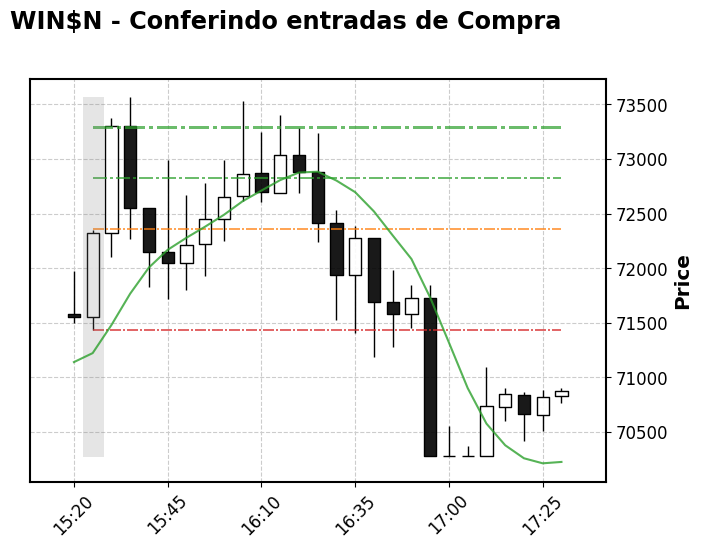

In [20]:
n_index = 90
inicio = df_result_compra.iloc[n_index].data_Entry - timedelta(minutes=10)
fim = df_result_compra.iloc[n_index].data_Entry + timedelta(minutes=120)

stop = 1.
take1 = .5
take2 = 1.

candle_index = 1

dfpl = df.loc[inicio:fim]

candle_signal = dfpl.index[candle_index].strftime('%Y-%m-%d %H:%M:%S')
candle_end = dfpl.index[-1].strftime('%Y-%m-%d %H:%M:%S')

ponto_entrada = df_result_compra.iloc[n_index].preco_Entry
ponto_stop = ponto_entrada - ((ponto_entrada - dfpl['low'].loc[candle_signal]) * stop)
ponto_take1 = ponto_entrada + ((ponto_entrada- dfpl['low'].loc[candle_signal]) * take1)
ponto_take2 = ponto_entrada + ((ponto_entrada - dfpl['low'].loc[candle_signal]) * take2)

lines = [[(candle_signal,ponto_stop),(candle_end, ponto_stop)],
         [(candle_signal,ponto_entrada),(candle_end, ponto_entrada)],
         [(candle_signal,ponto_take1),(candle_end, ponto_take1)],
        [(candle_signal,ponto_take2),(candle_end, ponto_take2)]]

adp = [mpf.make_addplot(dfpl.hma, color='tab:green', width=1.5, alpha=0.8),]

alines = dict(alines=lines, linestyle='-.', colors=['tab:red', 'tab:orange', 'tab:green', 'tab:green'], alpha=0.7, linewidths=[1.2,1.2,1.5,2.2,])
vlines=dict(vlines=candle_signal,linewidths=15, alpha=0.2, colors='tab:gray')
mpf.plot(dfpl, title=f'{ticker} - Conferindo entradas de Compra', type='candle', style='classic', vlines=vlines, alines=alines, addplot=adp)

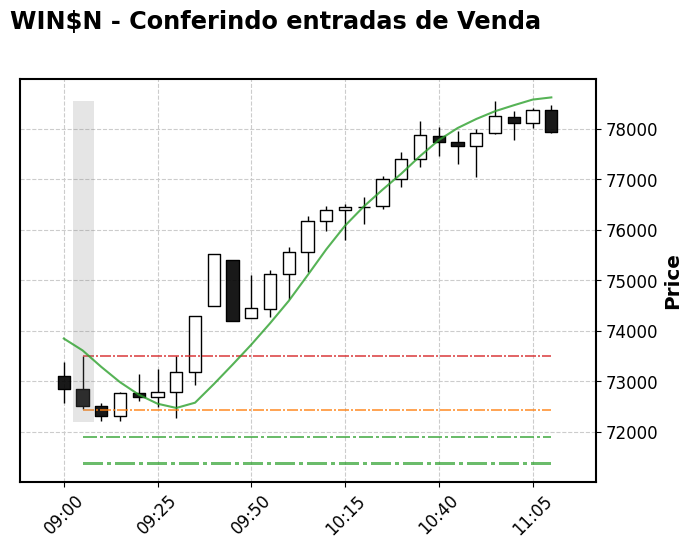

In [21]:
n_index = 100
minutes_ago = 10
candle_index = 1

if n_index == 0:
    minutes_ago = 15

inicio = df_result_venda.iloc[n_index].data_Entry - timedelta(minutes=minutes_ago)
fim = df_result_venda.iloc[n_index].data_Entry + timedelta(minutes=120)

stop = 1.
take1 = .5
take2 = 1.

dfpl = df.loc[inicio:fim]

candle_signal = dfpl.index[candle_index].strftime('%Y-%m-%d %H:%M:%S')
candle_end = dfpl.index[-1].strftime('%Y-%m-%d %H:%M:%S')

ponto_entrada = df_result_venda.iloc[n_index].preco_Entry
ponto_stop = ponto_entrada + ((dfpl['high'].loc[candle_signal] - ponto_entrada) * stop)
ponto_take1 = ponto_entrada - ((dfpl['high'].loc[candle_signal] - ponto_entrada) * take1)
ponto_take2 = ponto_entrada - ((dfpl['high'].loc[candle_signal] - ponto_entrada) * take2)

lines = [[(candle_signal,ponto_stop),(candle_end, ponto_stop)],
         [(candle_signal,ponto_entrada),(candle_end, ponto_entrada)],
         [(candle_signal,ponto_take1),(candle_end, ponto_take1)],
        [(candle_signal,ponto_take2),(candle_end, ponto_take2)]]

adp = [mpf.make_addplot(dfpl.hma, color='tab:green', width=1.5, alpha=0.8),]

alines = dict(alines=lines, linestyle='-.', colors=['tab:red', 'tab:orange', 'tab:green', 'tab:green'], alpha=0.7, linewidths=[1.2,1.2,1.5,2.2,])
vlines=dict(vlines=candle_signal,linewidths=15, alpha=0.2, colors='tab:gray')
mpf.plot(dfpl, title=f'{ticker} - Conferindo entradas de Venda', type='candle', style='classic', vlines=vlines, alines=alines, addplot=adp)

# 4. Visualizando o resultado final



Backtest do Big Barra WIN$N

Início do backtest: 2020-01-02 09:00:00
Fim do backtest: 2023-04-11 14:10:00
Quantidade de dias: 1195 days 05:10:00

Quantidade total de operações: 3158
Quantidade de operações de compra: 1564
Quantidade de operações de venda: 1594

Média de operações por dia: 3.9 operações
Máximo de operações por dia: 9 operações

Soma percentual de operações de compra: -39.89%
Soma percentual de operações de venda: 20.35%

Taxa de acerto: 48.64%

Resultado final: -19.54%
Média percentual de lucro por trade: -0.0241%


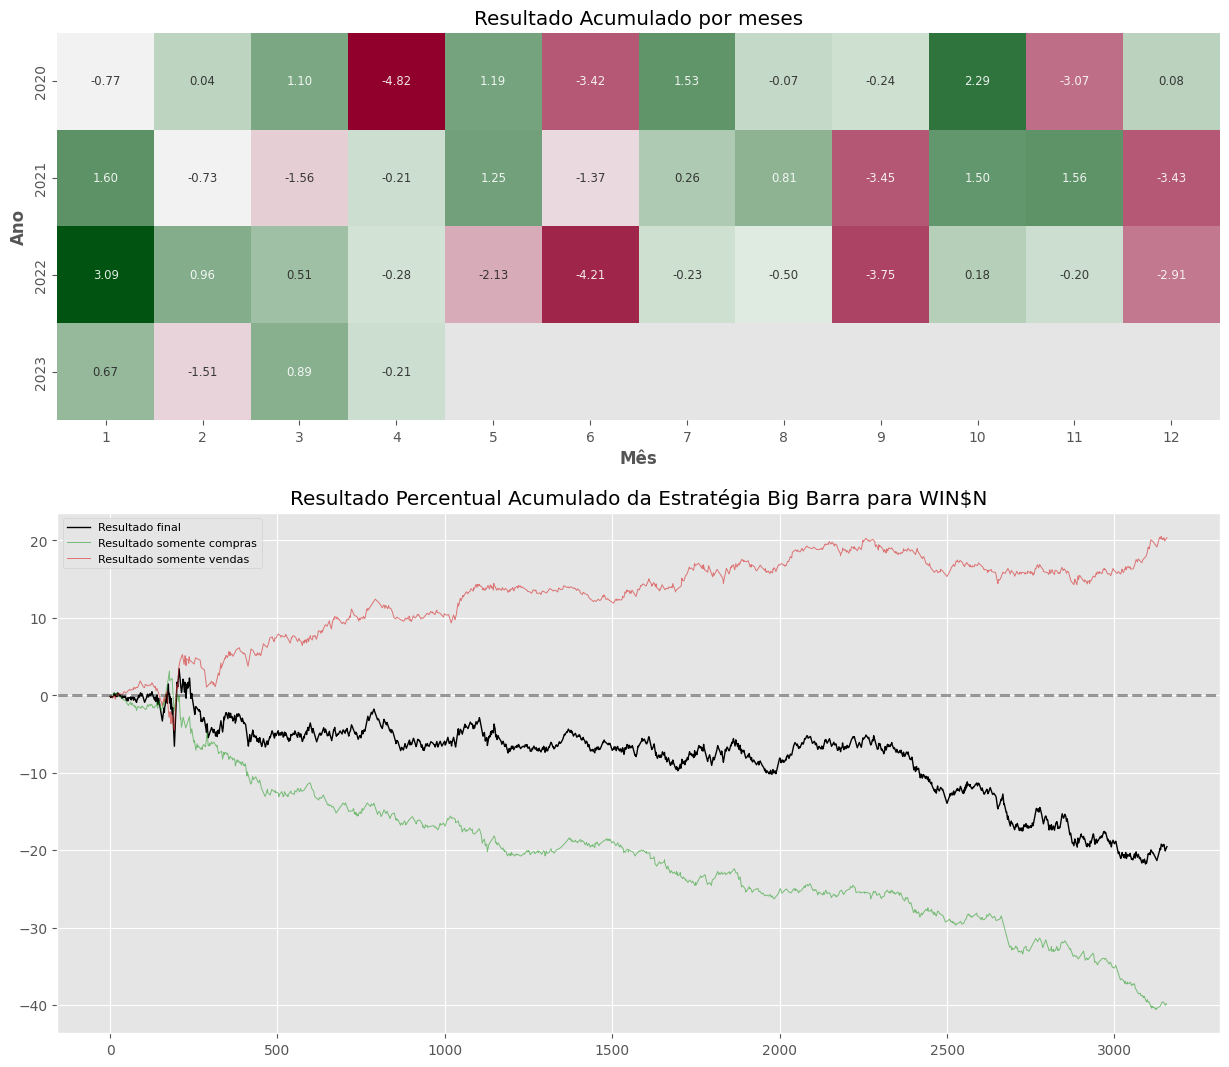

In [22]:
soma_compra = df_final[df_final['tipo'] == 'COMPRA']['Result_Final'].sum()
soma_venda = df_final[df_final['tipo'] == 'VENDA']['Result_Final'].sum()

qtd_compra = df_final[df_final['tipo'] == 'COMPRA']['Result_Final'].count()
qtd_venda = df_final[df_final['tipo'] == 'VENDA']['Result_Final'].count()

acertos = len(df_final[df_final['Result_Final'] > 0])
perdas = len(df_final[df_final['Result_Final'] <= 0])

contagem_operacoes = df_final.groupby('dia')['tipo'].count()
soma_resultados = df_final.groupby('dia')['Result_Final'].sum()

print(f'\n\nBacktest do Big Barra {ticker}')

print(f'\nInício do backtest: {df.index[0]}')
print(f'Fim do backtest: {df.index[-1]}')
print(f'Quantidade de dias: {df.index[-1] - df.index[0]}')

print(f'\nQuantidade total de operações: {len(df_final)}')
print(f'Quantidade de operações de compra: {qtd_compra}')
print(f'Quantidade de operações de venda: {qtd_venda}')

print(f'\nMédia de operações por dia: {round(contagem_operacoes.mean(), 2)} operações')
print(f'Máximo de operações por dia: {round(contagem_operacoes.max(), 2)} operações')

print(f'\nSoma percentual de operações de compra: {round(soma_compra, 2)}%')
print(f'Soma percentual de operações de venda: {round(soma_venda, 2)}%')

print(f'\nTaxa de acerto: {round((acertos/(acertos+perdas))*100, 2)}%')

print(f'\nResultado final: {round(soma_compra + soma_venda, 2)}%')
print(f'Média percentual de lucro por trade: {round(soma_resultados.mean(), 4)}%')

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 1, figsize=(15,24), gridspec_kw={'height_ratios': [4, 1]})
ax[1].set_title(f'Resultado Percentual Acumulado da Estratégia Big Barra para {ticker}')
ax[1].plot(df_final['Result_Final'].cumsum(), label='Resultado final', lw=1, color='black')
ax[1].plot(df_final[df_final['tipo'] == 'COMPRA']['Result_Final'].cumsum(), color='tab:green', label='Resultado somente compras', alpha=0.6, lw=0.7)
ax[1].plot(df_final[df_final['tipo'] == 'VENDA']['Result_Final'].cumsum(), color='tab:red', label='Resultado somente vendas', alpha=0.6, lw=0.7)
ax[1].axhline(0, color='black', ls='--', alpha=0.4)
ax[1].legend(prop={'size':8})

ax[0].set_title('Resultado Acumulado por meses')
rdgn = sns.diverging_palette(h_neg=5, h_pos=130, s=100, l=30, sep=10, center='light', as_cmap=True)
sns.heatmap(result_pivot, cmap=rdgn, square=True, cbar=False, annot=True,
            fmt='.2f', linewidths=0, annot_kws={'size': 'small', 'alpha': 0.9}, ax=ax[0])

ax[0].set_ylabel('Ano')
ax[0].set_xlabel('Mês')

fig.subplots_adjust(hspace=-0.58)
#fig.tight_layout()
fig.show();

# 5. Limitando a quantidade máxima de operações

In [23]:
qtd_entradas_por_dia = int(round(contagem_operacoes.mean(), 2))

dias = np.unique(df_final['dia'].values)
chaves = []

for dia in dias:
    chaves.append(df_final[df_final.dia  == str(dia)].iloc[:qtd_entradas_por_dia, :].data_Entry)
    
flat_list = [item for sublist in chaves for item in sublist]
df_ff = df_final.loc[df_final.data_Entry.isin(flat_list)]



Backtest do Big Barra WIN$N com limitação de entradas por dia

Início do backtest: 2020-01-02 09:00:00
Fim do backtest: 2023-04-11 14:10:00
Quantidade de dias: 1195 days 05:10:00

Quantidade total de operações: 2233
Quantidade de operações de compra: 1106
Quantidade de operações de venda: 1127

Média de operações por dia: 2.76 operações
Máximo de operações por dia: 3 operações

Soma percentual de operações de compra: -26.49%
Soma percentual de operações de venda: 16.46%

Taxa de acerto: 49.57%

Resultado final: -10.03%
Média percentual de lucro por trade: -0.0124%


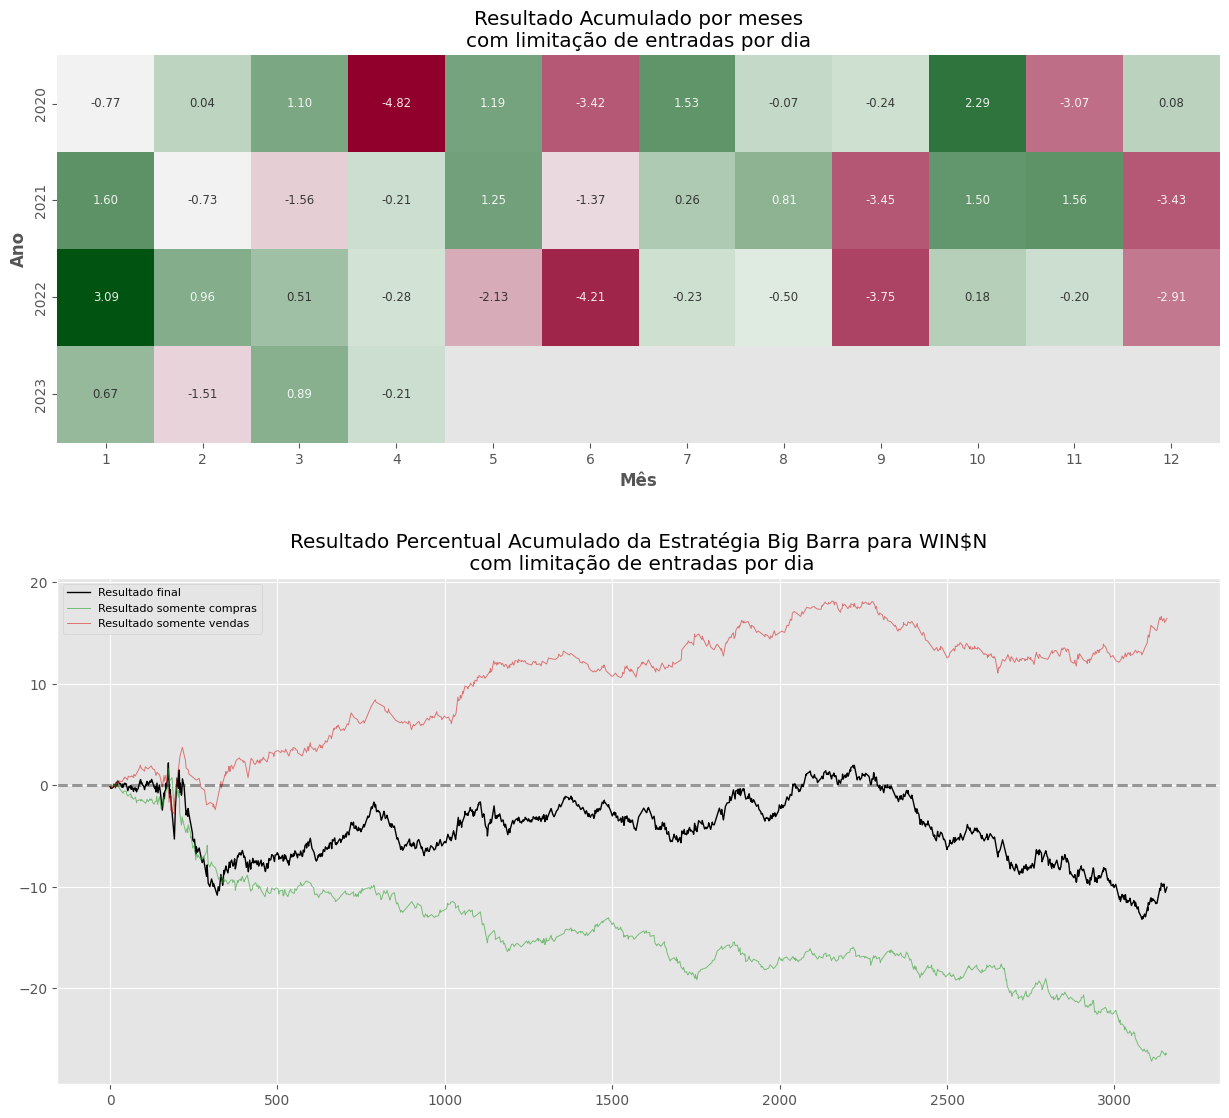

In [24]:
soma_compra = df_ff[df_ff['tipo'] == 'COMPRA']['Result_Final'].sum()
soma_venda = df_ff[df_ff['tipo'] == 'VENDA']['Result_Final'].sum()

qtd_compra = df_ff[df_ff['tipo'] == 'COMPRA']['Result_Final'].count()
qtd_venda = df_ff[df_ff['tipo'] == 'VENDA']['Result_Final'].count()

acertos = len(df_ff[df_ff['Result_Final'] > 0])
perdas = len(df_ff[df_ff['Result_Final'] <= 0])

contagem_operacoes = df_ff.groupby('dia')['tipo'].count()
soma_resultados = df_ff.groupby('dia')['Result_Final'].sum()

print(f'\n\nBacktest do Big Barra {ticker} com limitação de entradas por dia')

print(f'\nInício do backtest: {df.index[0]}')
print(f'Fim do backtest: {df.index[-1]}')
print(f'Quantidade de dias: {df.index[-1] - df.index[0]}')

print(f'\nQuantidade total de operações: {len(df_ff)}')
print(f'Quantidade de operações de compra: {qtd_compra}')
print(f'Quantidade de operações de venda: {qtd_venda}')

print(f'\nMédia de operações por dia: {round(contagem_operacoes.mean(), 2)} operações')
print(f'Máximo de operações por dia: {round(contagem_operacoes.max(), 2)} operações')

print(f'\nSoma percentual de operações de compra: {round(soma_compra, 2)}%')
print(f'Soma percentual de operações de venda: {round(soma_venda, 2)}%')

print(f'\nTaxa de acerto: {round((acertos/(acertos+perdas))*100, 2)}%')

print(f'\nResultado final: {round(soma_compra + soma_venda, 2)}%')
print(f'Média percentual de lucro por trade: {round(soma_resultados.mean(), 4)}%')

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 1, figsize=(15,24), gridspec_kw={'height_ratios': [4, 1]})
ax[1].set_title(f'Resultado Percentual Acumulado da Estratégia Big Barra para {ticker}\n com limitação de entradas por dia')
ax[1].plot(df_ff['Result_Final'].cumsum(), label='Resultado final', lw=1, color='black')
ax[1].plot(df_ff[df_ff['tipo'] == 'COMPRA']['Result_Final'].cumsum(), color='tab:green', label='Resultado somente compras', alpha=0.6, lw=0.7)
ax[1].plot(df_ff[df_ff['tipo'] == 'VENDA']['Result_Final'].cumsum(), color='tab:red', label='Resultado somente vendas', alpha=0.6, lw=0.7)
ax[1].axhline(0, color='black', ls='--', alpha=0.4)
ax[1].legend(prop={'size':8})

ax[0].set_title('Resultado Acumulado por meses\ncom limitação de entradas por dia')
rdgn = sns.diverging_palette(h_neg=5, h_pos=130, s=100, l=30, sep=10, center='light', as_cmap=True)
sns.heatmap(result_pivot, cmap=rdgn, square=True, cbar=False, annot=True,
            fmt='.2f', linewidths=0, annot_kws={'size': 'small', 'alpha': 0.9}, ax=ax[0])

ax[0].set_ylabel('Ano')
ax[0].set_xlabel('Mês')

fig.subplots_adjust(hspace=-0.54)
fig.show();